In [0]:
import sys
import csv
import re
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

In [0]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super(RNN, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
        self.fc = nn.Linear(hidden_dim*2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        #x = [sent len, batch size]

        embedded = self.dropout(self.embedding(x))

        #embedded = [sent len, batch size, emb dim]

        output, (hidden, cell) = self.rnn(embedded)

        #output = [sent len, batch size, hid dim * num directions]
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]

        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout

        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))

        #hidden = [batch size, hid dim * num directions]

        return self.fc(hidden.squeeze(0))

In [0]:
def case_normalization(msg):
    return msg.strip().lower()

def remove_delimiters(msg):
    return filter(None, re.split('[ ,.!]', msg))

def pre_process_msg(msg):
    return remove_delimiters(case_normalization(msg))

def parse_data(input_path):
    with open(input_path, 'r') as fd:
        rd = csv.reader(fd, delimiter='\t', quotechar='"')
        fields = rd.next()
        data = {}
        for field in fields:
            data[field] = []
        for row in rd:
            for i, token in enumerate(row):
                data[fields[i]].append(token)
        return data

def get_word2idx(tokenized_corpus):
    vocabulary = []
    for sentence in tokenized_corpus:
        for token in sentence:
            if token not in vocabulary:
                vocabulary.append(token)
    word2idx = {w : idx + 1 for (idx, w) in enumerate(vocabulary)}
    word2idx['<pad>'] = 0
    return word2idx

def get_model_inputs(tokenized_corpus, word2idx, max_len, labels = []):
    vectorized_sents = [[word2idx[tok] for tok in sent if tok in word2idx] for sent in tokenized_corpus]
    # Create a tensor of a fixed size filled with zeroes for padding
    sent_tensor = Variable(torch.zeros((len(vectorized_sents), max_len))).long()
    sent_lengths = [len(sent) for sent in vectorized_sents]
    # Fill it with vectorized sentences
    for idx, (sent, sentlen) in enumerate(zip(vectorized_sents, sent_lengths)):
        sent_tensor[idx, :sentlen] = LongTensor(sent)
    label_tensor = FloatTensor(labels)
    return sent_tensor, label_tensor

def predict_value(input_tensor, num_of_classes):
    prediction = torch.sigmoid(model(input_tensor)).item()
    return num_of_classes - 1 if prediction == 1 else int(prediction * num_of_classes)

On epoch 1 out of 10
Starting batch loop...
[01/10] mean_loss : 0.66, Perplexity : 1.94
[01/10] mean_loss : 0.65, Perplexity : 1.92
[01/10] mean_loss : 0.62, Perplexity : 1.86
[01/10] mean_loss : 0.65, Perplexity : 1.91
[01/10] mean_loss : 0.65, Perplexity : 1.92
[01/10] mean_loss : 0.66, Perplexity : 1.94
[01/10] mean_loss : 0.64, Perplexity : 1.89
[01/10] mean_loss : 0.65, Perplexity : 1.92
[01/10] mean_loss : 0.61, Perplexity : 1.85
[01/10] mean_loss : 0.61, Perplexity : 1.84
[01/10] mean_loss : 0.64, Perplexity : 1.89
[01/10] mean_loss : 0.63, Perplexity : 1.89
[01/10] mean_loss : 0.62, Perplexity : 1.87
[01/10] mean_loss : 0.61, Perplexity : 1.85
[01/10] mean_loss : 0.62, Perplexity : 1.86
[01/10] mean_loss : 0.61, Perplexity : 1.84
[01/10] mean_loss : 0.65, Perplexity : 1.92
[01/10] mean_loss : 0.62, Perplexity : 1.85
[01/10] mean_loss : 0.62, Perplexity : 1.86
[01/10] mean_loss : 0.63, Perplexity : 1.87
[01/10] mean_loss : 0.63, Perplexity : 1.87
[01/10] mean_loss : 0.60, Perple

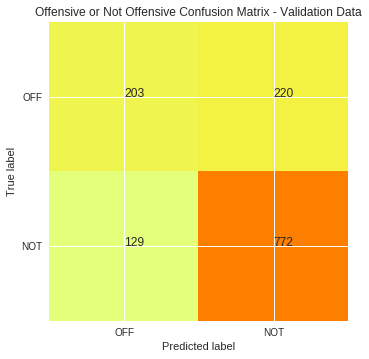

PREDICTING TESTING LABELS NOW
FINISHED PREDICTING TESTING LABELS


In [0]:
if __name__ == '__main__':

    # Parse the csv files into appropriate datasets
    model_dataset = parse_data('offenseval-training-v1.tsv')
    testing_dataset = parse_data('testset-taska.tsv')

    model_corpus = map(pre_process_msg, model_dataset['tweet'])
    labels = model_dataset['subtask_a']
    testing_corpus = map(pre_process_msg, testing_dataset['tweet'])

    # Filter out data that is not relevant to the subtask
    filtered_corpus = []
    filtered_labels = []
    for i, (tweet, label) in enumerate(zip(model_corpus, labels)):
        if label != "NULL":
            filtered_corpus.append(tweet)
            filtered_labels.append(label)
    model_corpus = filtered_corpus
    labels = filtered_labels

    # Generate classes for each label
    class2label = []
    label2class = {}
    for label in labels:
        if label not in label2class:
            label2class[label] = len(class2label)
            class2label.append(label)
    classes = map(lambda label : label2class[label], labels)

    # Fix seeds for consistent results
    SEED = 234
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

    # Split the model dataset into training data and validation data
    model_size = len(model_corpus)
    validation_size = model_size // 10
    start = random.randint(0, model_size)
    end = start + validation_size
    excess = max(end - model_size, 0)
    training_corpus = model_corpus[:start] + model_corpus[end - model_size:]
    training_target = classes[:start] + classes[end - model_size:]
    validation_corpus = model_corpus[start : end] + model_corpus[:excess]
    validation_target = classes[start : end] + classes[:excess]

    # Other pre-processing helper variables
    USE_CUDA = torch.cuda.is_available()
    FloatTensor = torch.cuda.FloatTensor if USE_CUDA else torch.FloatTensor
    LongTensor = torch.cuda.LongTensor if USE_CUDA else torch.LongTensor
    ByteTensor = torch.cuda.ByteTensor if USE_CUDA else torch.ByteTensor

    # Get word2idx and intialise tensors
    word2idx = get_word2idx(training_corpus)
    max_len = np.max(np.array([len(sent) for sent in training_corpus]))
    training_data_tensor, training_label_tensor = get_model_inputs(training_corpus, word2idx, max_len, training_target)
    validation_data_tensor, _ = get_model_inputs(validation_corpus, word2idx, max_len)
    testing_data_tensor, _ = get_model_inputs(testing_corpus, word2idx, max_len)

    # Hyperparameters
    EMBEDDING_SIZE = 100
    HIDDEN_LAYER_SIZE = 100
    LR = 0.01
    EPOCH = 10
    OUTPUT_DIM = 1
    N_LAYERS = 2
    BIDIRECTIONAL = True
    DROPOUT = 0.5
    BATCH_SIZE = 100

    # Initialise RNN model
    model = RNN(len(word2idx), EMBEDDING_SIZE, HIDDEN_LAYER_SIZE, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT)
    device = torch.device('cuda:0' if USE_CUDA else 'cpu')
    model = model.to(device)
    
    loss_function = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=LR)

    # Train the model
    for epoch in range(1, EPOCH + 1):
        print("On epoch " + str(epoch) + " out of " + str(EPOCH))
        total_loss = 0
        losses = []
        model.train()
        print("Starting batch loop...")
        for i in range(0, len(training_data_tensor), BATCH_SIZE):
            model.zero_grad()
            inputs = training_data_tensor[i : i + BATCH_SIZE].permute(1, 0).to(device)
            targets = training_label_tensor[i : i + BATCH_SIZE].unsqueeze(1).to(device)
            preds = model(inputs)
            loss = loss_function(preds, targets)
            losses.append(loss.item())
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()
            if i > 0 and i % 500 == 0:
                print("[%02d/%d] mean_loss : %0.2f, Perplexity : %0.2f" % (epoch, EPOCH, np.mean(losses), np.exp(np.mean(losses))))
                losses = []
        print("Finished batch loop...")

    # Test the model on the validation data
    model.eval()
    preds = []
    print("PREDICTING LABELS ON VALIDATION DATA")
    for validation_input in validation_data_tensor:
        model.zero_grad()
        predicted_class = predict_value(validation_input.unsqueeze(1).to(device), len(class2label))
        preds.append(predicted_class)
    print("COMPLETED VALIDATION DATA LABEL PREDICTION")

    # Print accuracy and macro f1 measure for validation predictions
    acc = accuracy_score(validation_target, preds)
    f1 = f1_score(validation_target, preds, average = 'macro')
    print("Accuracy: " + str(acc))
    print("Macro F1 Average: " + str(f1))

    # Plot confusion matrix of validation predictions
    cm = confusion_matrix(validation_target, preds)
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    tick_marks = np.arange(len(class2label))
    plt.xticks(tick_marks, class2label)
    plt.yticks(tick_marks, class2label)
    plt.title('Offensive or Not Offensive Confusion Matrix - Validation Data')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    for i in range(len(class2label)):
        for j in range(len(class2label)):
            plt.text(j, i, str(cm[i][j]))
    plt.show()

    # Predict labels for testing data
    model.eval()
    preds = []
    print("PREDICTING TESTING LABELS NOW")
    for testing_input in testing_data_tensor:
        model.zero_grad()
        predicted_label = class2label[predict_value(testing_input.unsqueeze(1).to(device), len(class2label))]
        preds.append(predicted_label)
    print("FINISHED PREDICTING TESTING LABELS")

    # Write predictions for testing data into output csv file
    csv_data = []
    id_values = testing_dataset['id']
    for i, id_val in enumerate(id_values):
        csv_data.append([id_val, preds[i]])
    with open('predictions.csv', 'w') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerows(csv_data)